In [1]:
# imports
from osgeo import gdal
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report


# consts
predictedLandcoverLocationUNET = 'data/predicted_lc_UNET.tif'
predictedLandcoverLocationUNET_HR = 'data/predicted_lc_HighRez_UNET.tif'
predictedLandcoverLocationCNN = 'data/predicted_lc_CNN.tif'
targetLandcoverLocation = 'data/target_lc.tif'

landcovertypes = {11 : 'Open Water', 21 : 'Developed - open space', 22 : 'Developed - low', 
                  23 : 'Developed - med', 24 : 'Developed - high', 31 : 'Barren Land',
                  42 : 'Evergreen Forest', 43 : 'Mixed Forest',
                  52 : 'Shrub/Scrub', 71 : 'Grassland/Herbaceous',
                  82 : 'Cultivated Crops', 90 : 'Woody Wetlands',
                  95 : 'Emergent Herbaceous Wetlands'}

In [2]:
def openGeoTiff(location):   
    dataset = gdal.Open(location, gdal.GA_ReadOnly)
    array = np.array([dataset.GetRasterBand(1).ReadAsArray().flatten()])
    for x in range(2, dataset.RasterCount + 1):
        band = dataset.GetRasterBand(x)
        array = np.append(array,[band.ReadAsArray().flatten()],axis=0)
    
    dataset = None
    return array[0]


In [3]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          yTitle = 'True Values',
                          xTitle = 'Predicted Values'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    #print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        fmt = '.2f'
    else:
        fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(yTitle)
    plt.xlabel(xTitle)
    

In [4]:
def LandCoverComparison(source, predictions, titleText, yTitle, xTitle, sourceArray = None, predArray = None):
    import warnings
    warnings.filterwarnings("ignore")

    # get values
    if (predArray is None):
        predicted = openGeoTiff(predictions)
    else:
        predicted = predArray
        
    if (sourceArray is None):
        target = openGeoTiff(source)
    else:
        target = sourceArray
        
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(target, predicted, labels = list(landcovertypes.keys()))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(18, 16))
    plot_confusion_matrix(cnf_matrix, classes=list(landcovertypes.values()),
                          normalize = False,
                          title= titleText + ' - no normalization', 
                          yTitle = yTitle, xTitle = xTitle)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(target, predicted, labels = list(landcovertypes.keys()))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(18, 16))
    plot_confusion_matrix(cnf_matrix, classes=list(landcovertypes.values()),
                          normalize = True,
                          title= titleText +' - with normalization', 
                          yTitle = yTitle, xTitle = xTitle)
    plt.show()

    print(classification_report(target, predicted, 
                                           labels = list(landcovertypes.keys()), 
                                           target_names = list(landcovertypes.values())))



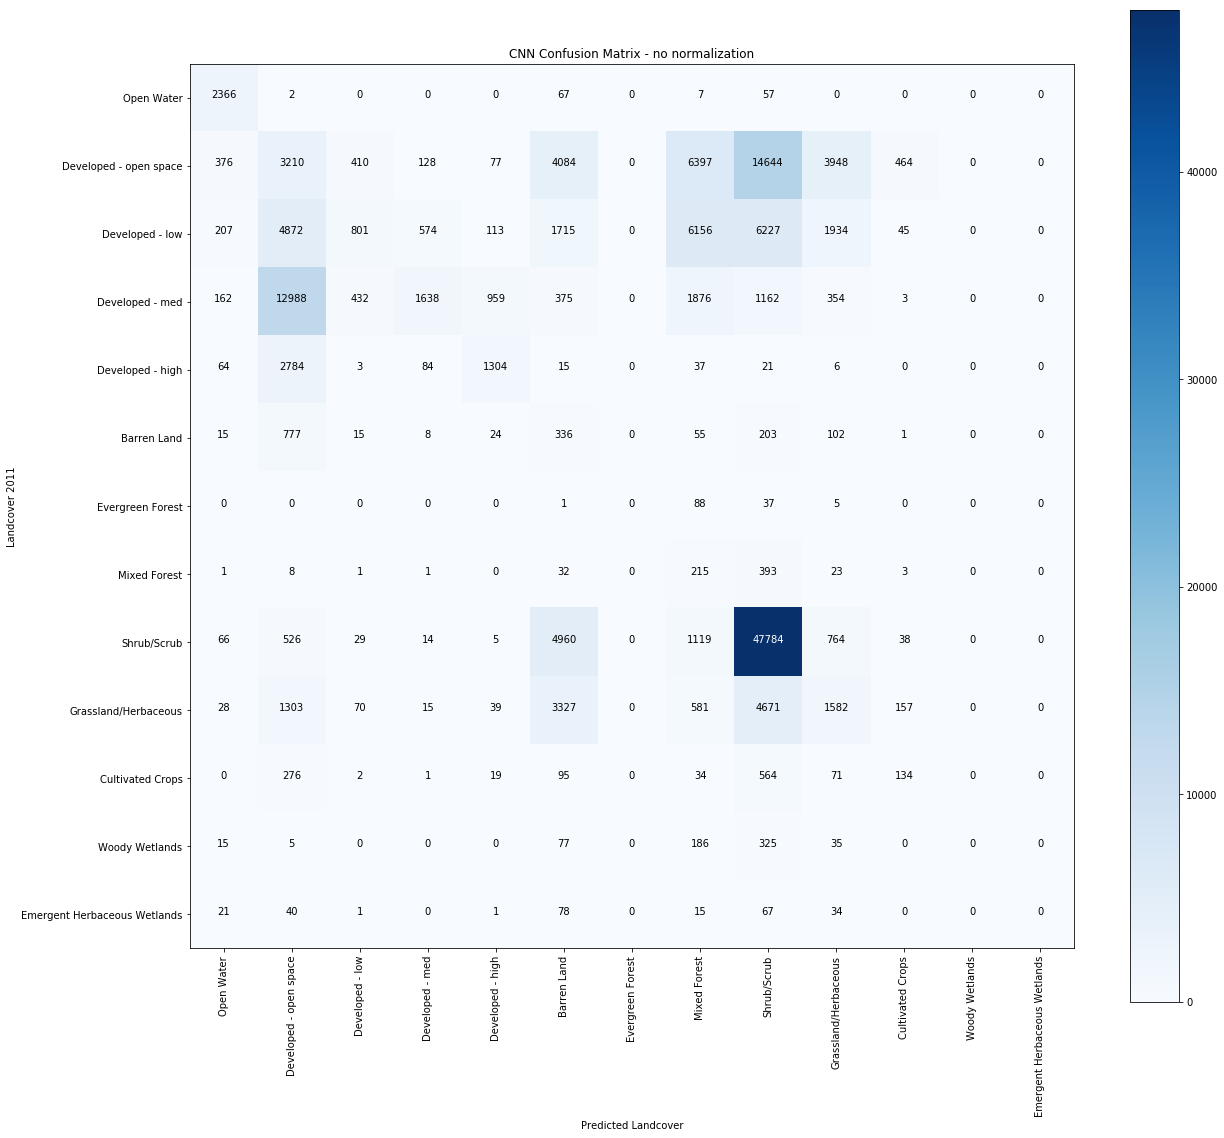

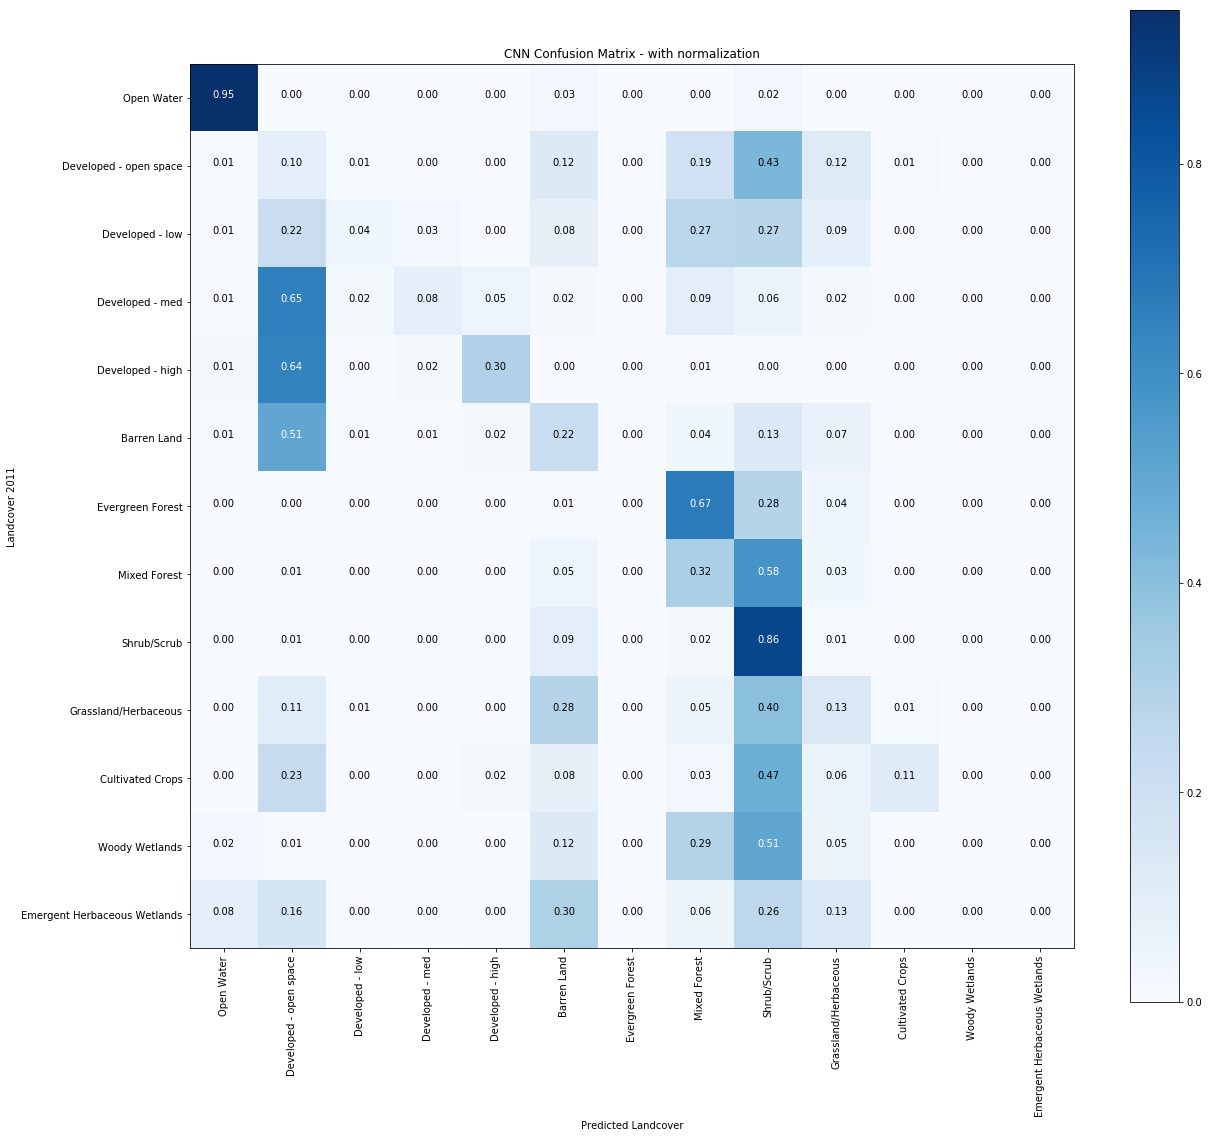

                              precision    recall  f1-score   support

                  Open Water       0.71      0.95      0.81      2499
      Developed - open space       0.12      0.10      0.11     33738
             Developed - low       0.45      0.04      0.07     22644
             Developed - med       0.67      0.08      0.15     19949
            Developed - high       0.51      0.30      0.38      4318
                 Barren Land       0.02      0.22      0.04      1536
            Evergreen Forest       0.00      0.00      0.00       131
                Mixed Forest       0.01      0.32      0.02       677
                 Shrub/Scrub       0.63      0.86      0.73     55305
        Grassland/Herbaceous       0.18      0.13      0.15     11773
            Cultivated Crops       0.16      0.11      0.13      1196
              Woody Wetlands       0.00      0.00      0.00       643
Emergent Herbaceous Wetlands       0.00      0.00      0.00       257

                 a

In [5]:
# CCN Comparison
LandCoverComparison(targetLandcoverLocation, predictedLandcoverLocationCNN, 
                    'CNN Confusion Matrix', 'Landcover 2011', 'Predicted Landcover')

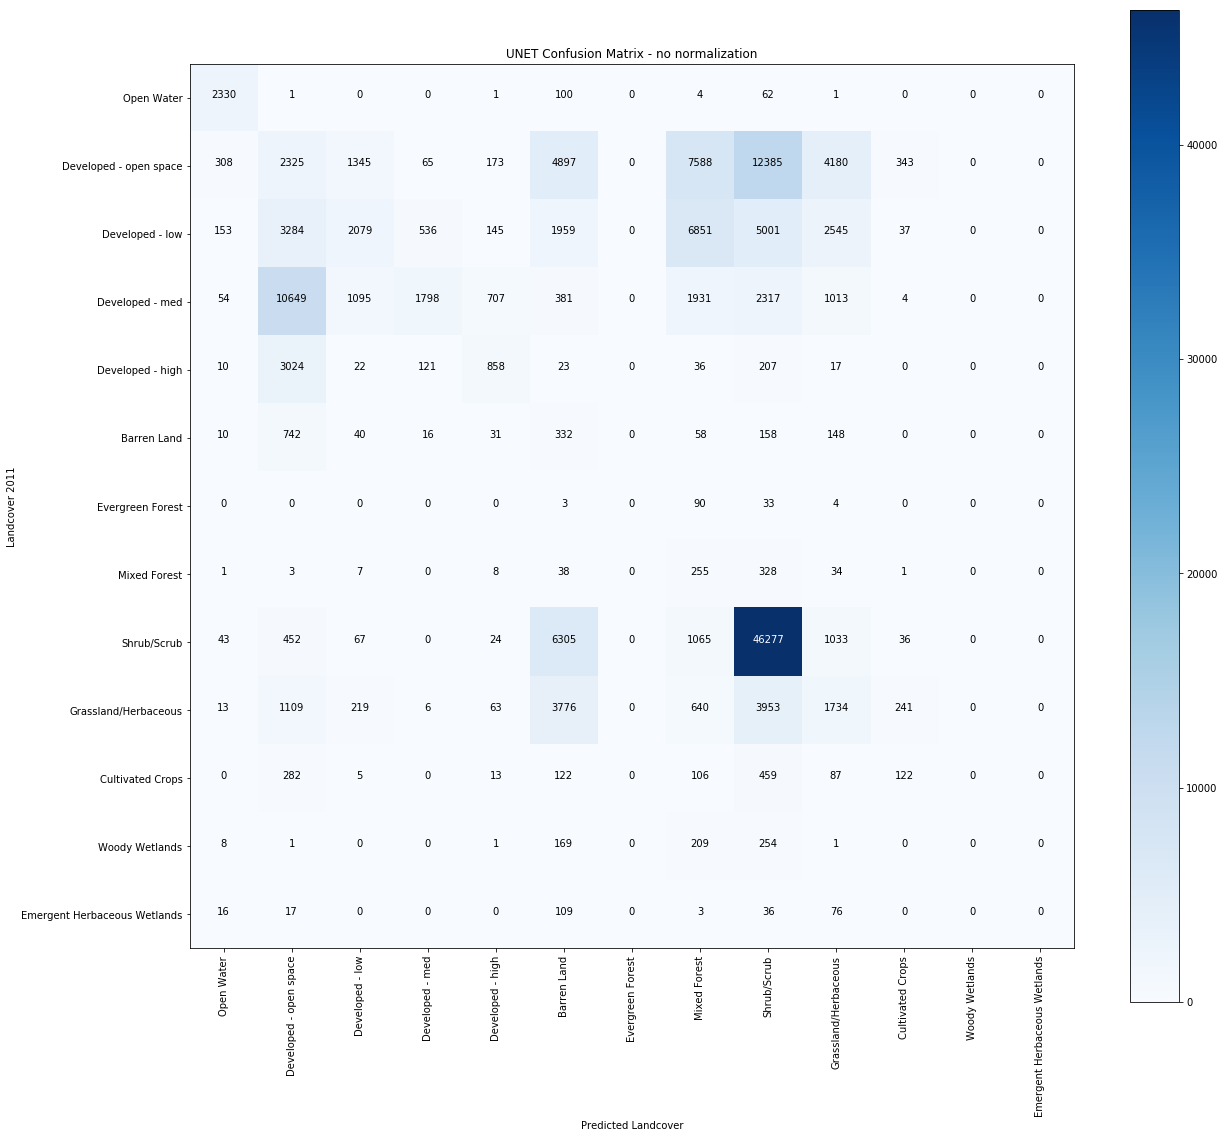

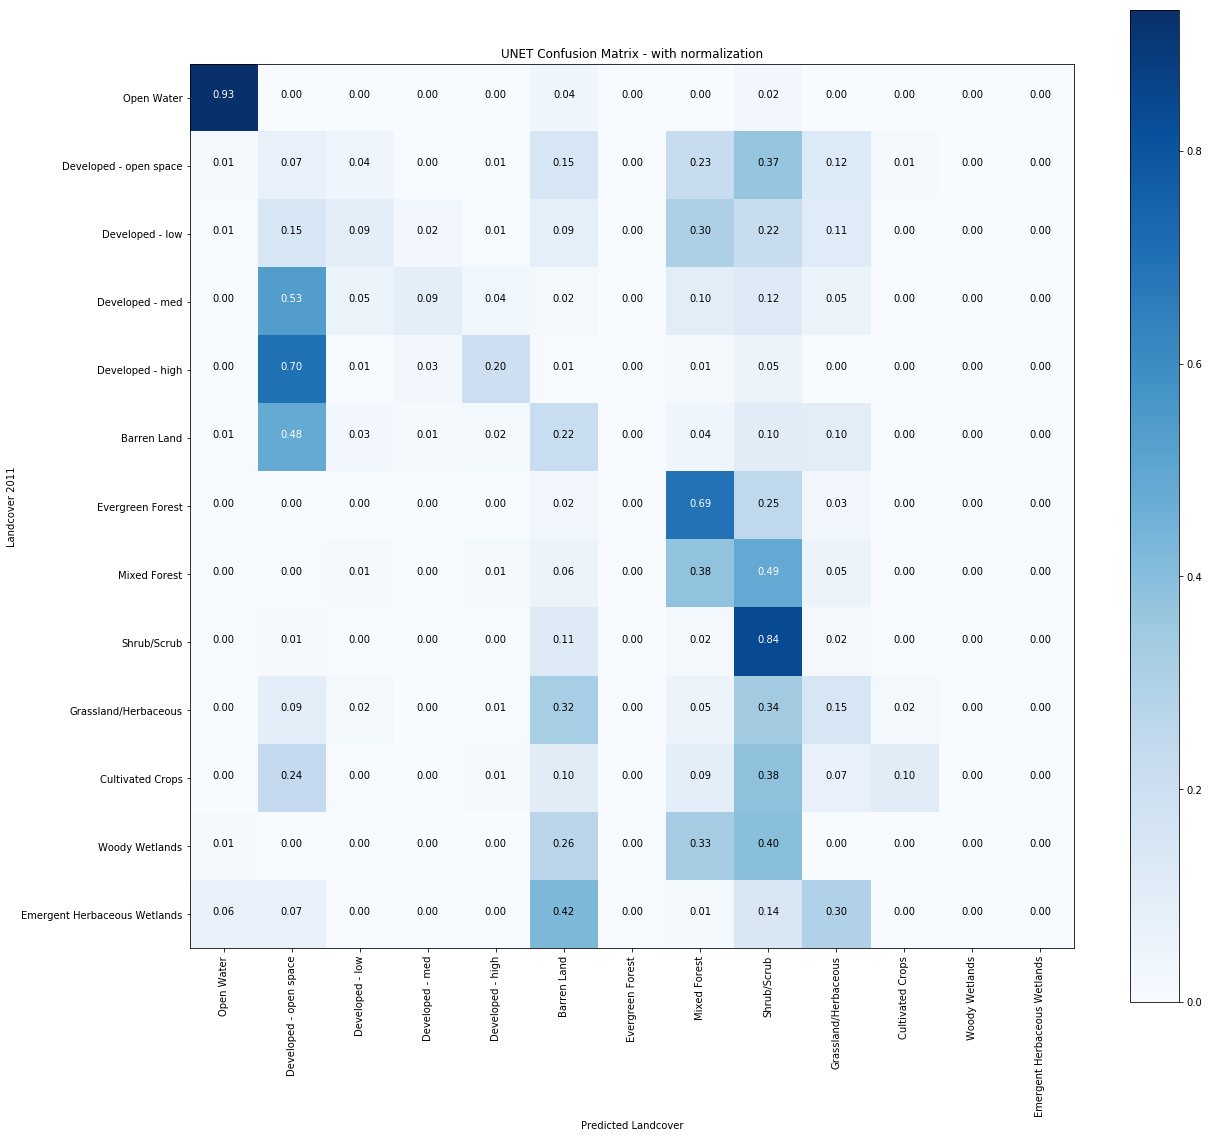

                              precision    recall  f1-score   support

                  Open Water       0.79      0.93      0.86      2499
      Developed - open space       0.11      0.07      0.08     33738
             Developed - low       0.43      0.09      0.15     22644
             Developed - med       0.71      0.09      0.16     19949
            Developed - high       0.42      0.20      0.27      4318
                 Barren Land       0.02      0.22      0.03      1536
            Evergreen Forest       0.00      0.00      0.00       131
                Mixed Forest       0.01      0.38      0.03       677
                 Shrub/Scrub       0.65      0.84      0.73     55305
        Grassland/Herbaceous       0.16      0.15      0.15     11773
            Cultivated Crops       0.16      0.10      0.12      1196
              Woody Wetlands       0.00      0.00      0.00       643
Emergent Herbaceous Wetlands       0.00      0.00      0.00       257

                 a

In [6]:
# CCN Comparison
LandCoverComparison(targetLandcoverLocation, predictedLandcoverLocationUNET, 
                    'UNET Confusion Matrix', 'Landcover 2011', 'Predicted Landcover')

In [11]:
def interpolate(array, width, multiplicty_x, multiplicity_y):
    if (len(arr)%width) != 0 :
        print('uneven length')

    newArr = []
    for i in range(0, int(len(arr)/width)):
        start = i*width
        end = ((i+1)*width)
        newArr.append(np.tile(arr[start:end], multiplicity_y))

    newArr = np.concatenate(newArr)
    newArr = np.repeat(newArr, multiplicty_x)
    return newArr
    
    

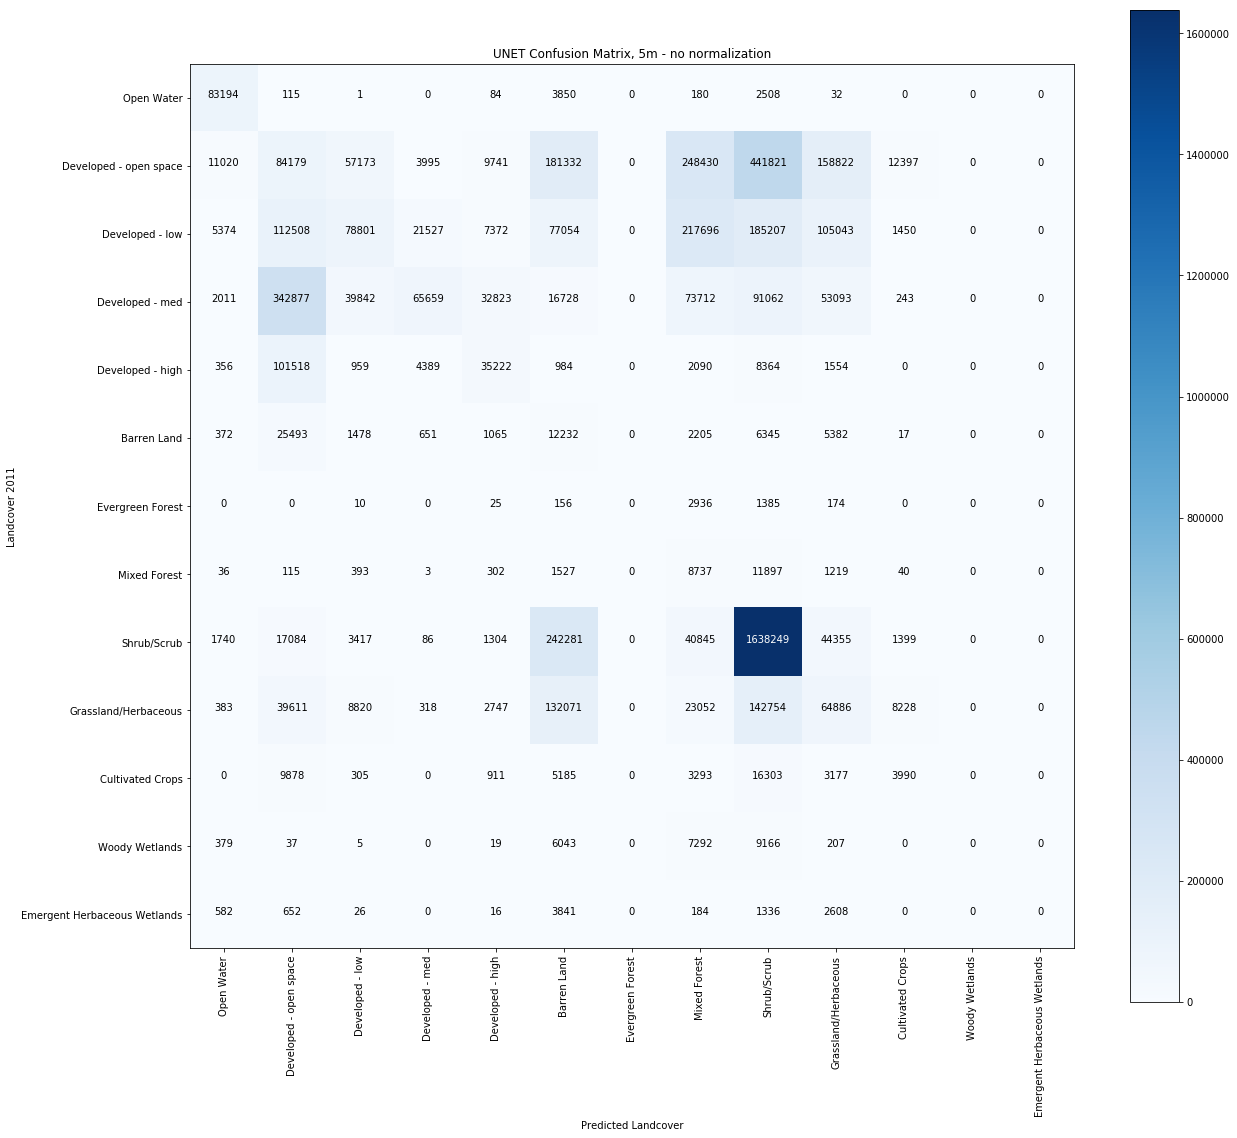

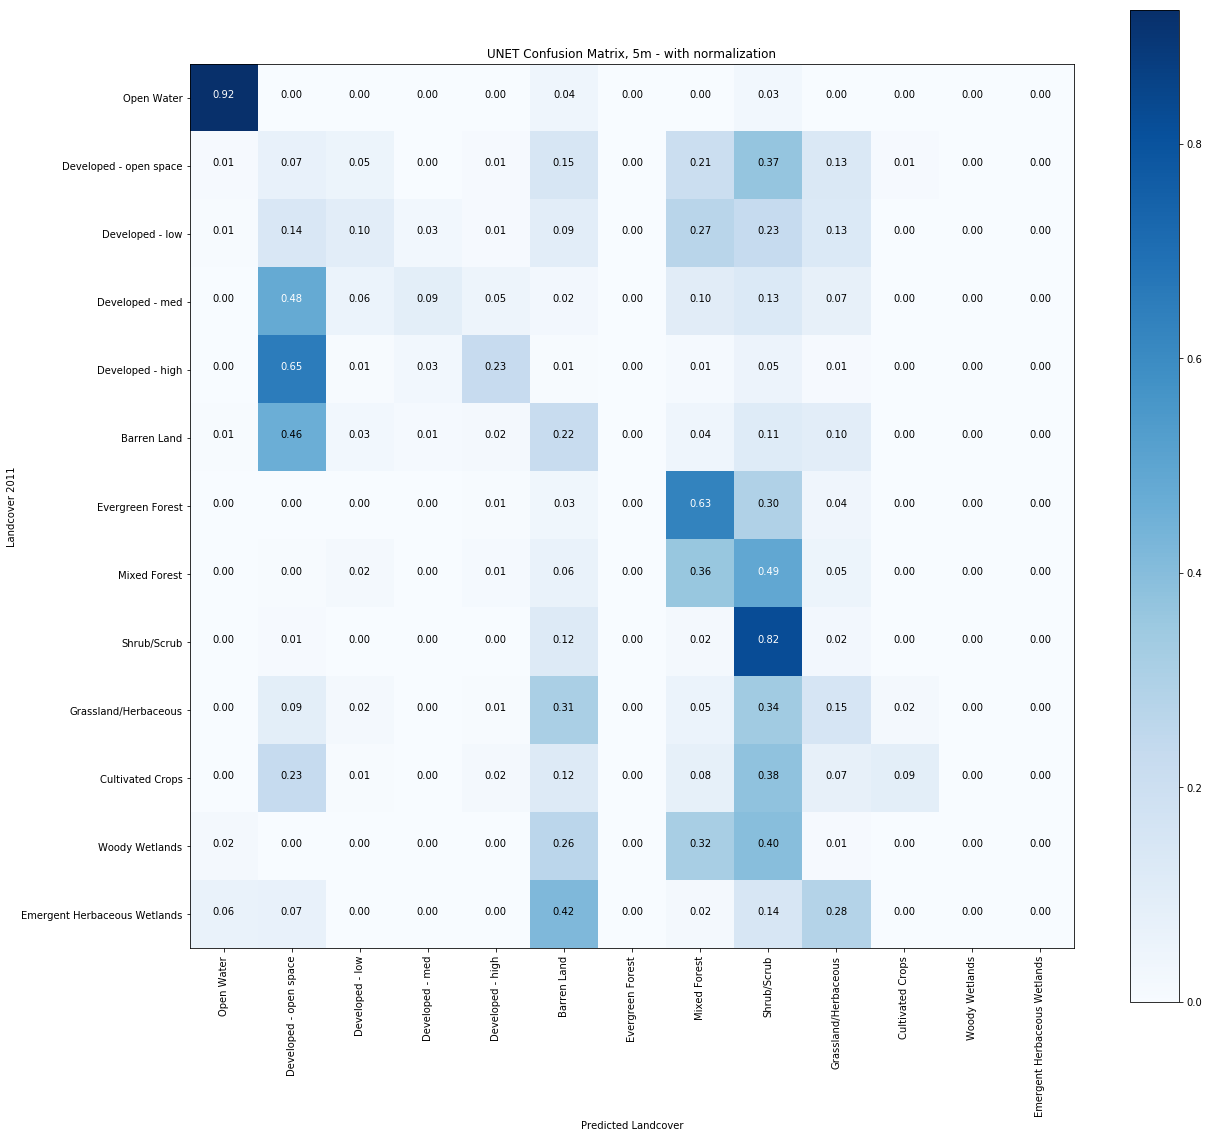

                              precision    recall  f1-score   support

                  Open Water       0.79      0.92      0.85     89964
      Developed - open space       0.11      0.07      0.09   1214568
             Developed - low       0.41      0.10      0.16    815184
             Developed - med       0.68      0.09      0.16    718164
            Developed - high       0.38      0.23      0.29    155448
                 Barren Land       0.02      0.22      0.03     55296
            Evergreen Forest       0.00      0.00      0.00      4716
                Mixed Forest       0.01      0.36      0.03     24372
                 Shrub/Scrub       0.64      0.82      0.72   1990980
        Grassland/Herbaceous       0.15      0.15      0.15    423828
            Cultivated Crops       0.14      0.09      0.11     43056
              Woody Wetlands       0.00      0.00      0.00     23148
Emergent Herbaceous Wetlands       0.00      0.00      0.00      9252

                 a

In [12]:
arr = openGeoTiff(targetLandcoverLocation)
newArr = interpolate(arr, 320, 6, 6)

# UNET Comparison, dense
LandCoverComparison(None, predictedLandcoverLocationUNET_HR, 
                    'UNET Confusion Matrix, 5m', 'Landcover 2011', 'Predicted Landcover',
                   sourceArray = newArr)